# Problem Description: Darcy Flow
**Governing PDE: $\quad −∇⋅(k(x,y)∇u(x,y))=f(x,y),x∈[0,1]$**


**Boundary Condition: $\quad u_{bc}(x,y) = 0, \quad x,y \in [0,1]$**

**Solution Operator: $G : k(x,y) \mapsto u(x,y)$**

branch net 입력: k(x,y)의 센서값</br>
trunk net 입력: x,y 그리드 좌표</br>
출력: 전체 압력장 u(x,y)

Reference: https://github.com/neuraloperator/neuraloperator/tree/main

In [21]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from neuralop.data.datasets import DarcyDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:0


In [22]:
# 데이터셋 생성 및 로더 설정
dataset = DarcyDataset(
    root_dir="C:/Users/admin/Desktop/김도형/코드/Dataset",
    n_train=2000, n_tests=[20, 20, 20],
    batch_size=50, test_batch_sizes=[20, 20, 20],
    train_resolution=32, test_resolutions=[16, 32, 64],
    download=True
)

train_loader = DataLoader(dataset.train_db, batch_size=50, shuffle=True, 
                          num_workers=2, pin_memory=True)
test_loaders = {res: DataLoader(db, batch_size=20, shuffle=False,
                                num_workers=2, pin_memory=True) 
                for res, db in dataset.test_dbs.items()}

Loading test db for resolution 16 with 20 samples 
Loading test db for resolution 32 with 20 samples 
Loading test db for resolution 64 with 20 samples 


In [3]:
batch = next(iter(train_loader))
print(batch.keys())
for k, v in batch.items():
    print(k, v.shape)

x_data = batch['x'].view(batch['x'].size(0), -1)
print(x_data.shape)

dict_keys(['x', 'y'])
x torch.Size([50, 1, 32, 32])
y torch.Size([50, 1, 32, 32])
torch.Size([50, 1024])


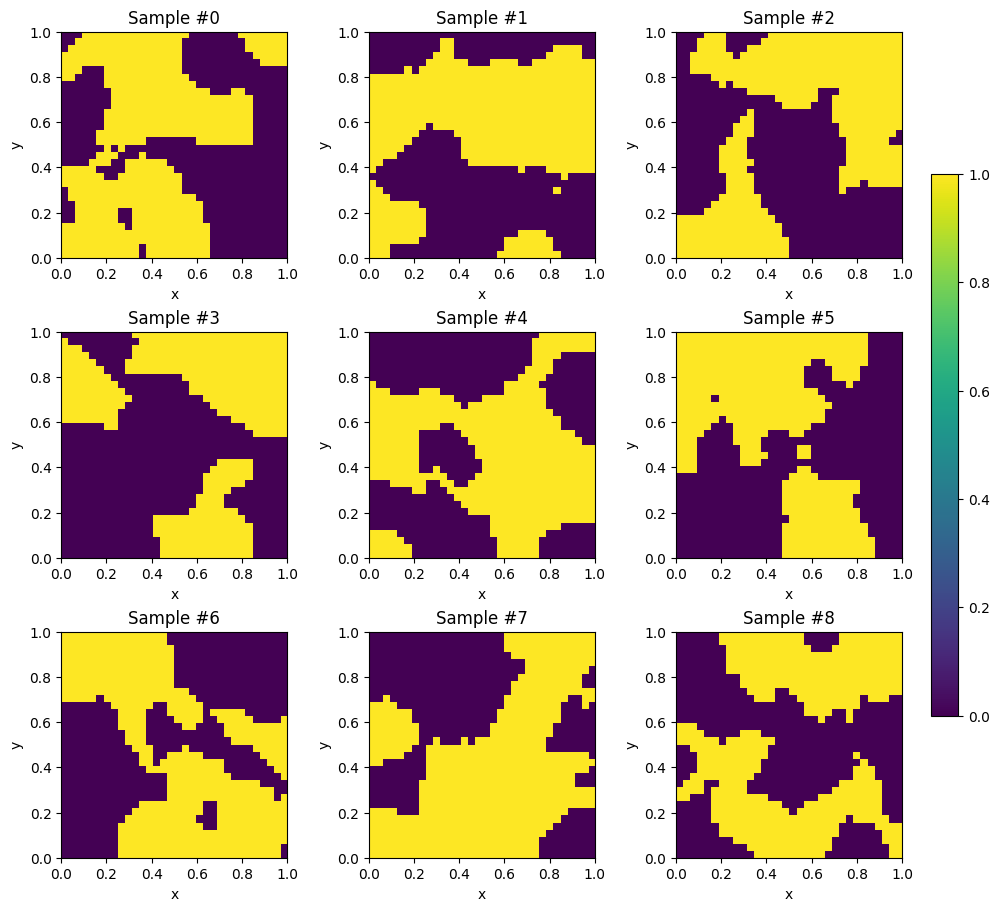

In [35]:
batch = next(iter(train_loader))
x_data = batch["x"]  # (B,C,Nx,Ny) or (B,Nx,Ny)

# (B,Nx,Ny)로 통일
if x_data.ndim == 4:
    x_data = x_data[:, 0, :, :]  # 첫 채널만

B, Nx, Ny = x_data.shape

fig, axes = plt.subplots(3, 3, figsize=(10, 9), constrained_layout=True)

# (선택) 전체 스케일 고정: 이진이면 0~1, 연속이면 min/max
vmin = float(x_data.min().cpu().item())
vmax = float(x_data.max().cpu().item())

for i, ax in enumerate(axes.ravel()[:9]):
    im = ax.imshow(
        x_data[i].detach().cpu().numpy(),
        extent=[0, 1, 0, 1],
        origin="lower",
        interpolation="nearest",
        vmin=vmin, vmax=vmax,
        aspect="equal",
    )
    ax.set_title(f"Sample #{i}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# colorbar를 전체 axes 기준으로 오른쪽에 배치
fig.colorbar(im, ax=axes, location="right", fraction=0.03, pad=0.02)
plt.savefig("C:/Users/admin/Desktop/김도형/코드/figure_20260213_labmeeting/branch_k_sample.png", dpi=300, bbox_inches="tight")
plt.show()


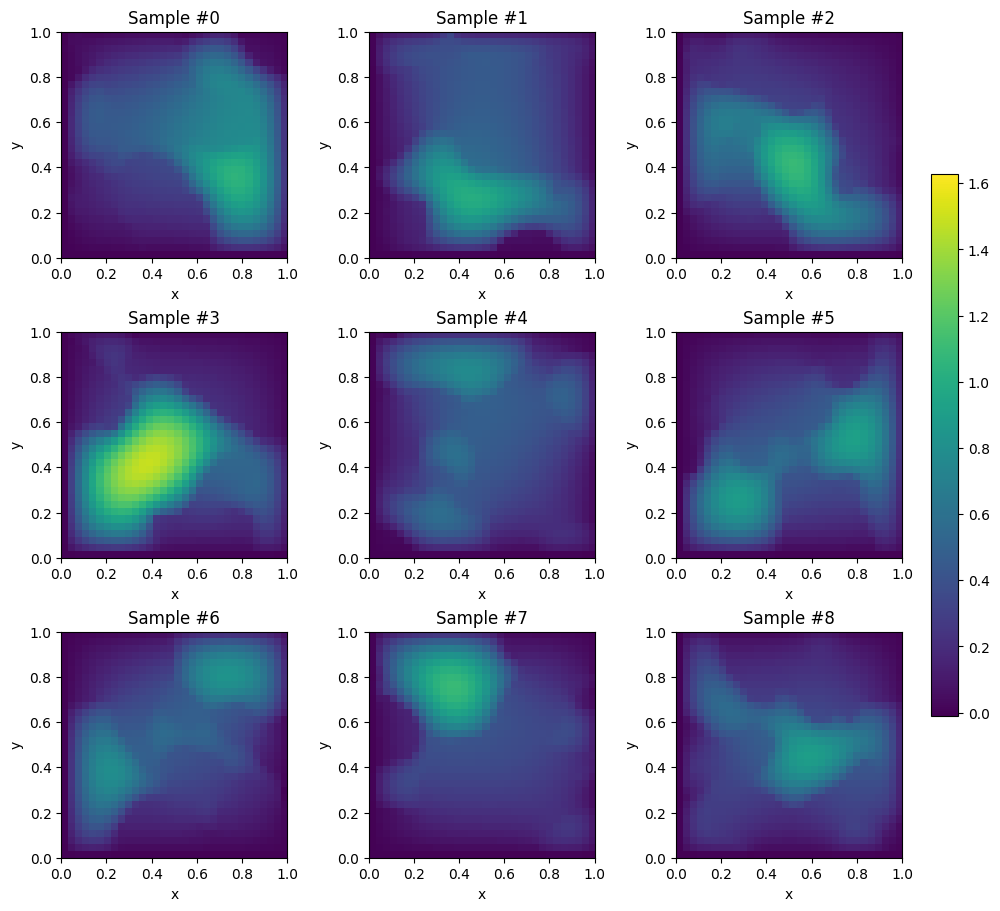

In [36]:
y_data = batch["y"]

if y_data.ndim == 4:
    y_data = y_data[:, 0, :, :]

B, Nx, Ny = y_data.shape

fig, axes = plt.subplots(3, 3, figsize=(10, 9), constrained_layout=True)

vmin = float(y_data.min().cpu().item())
vmax = float(y_data.max().cpu().item())

for i, ax in enumerate(axes.ravel()[:9]):
    im = ax.imshow(
        y_data[i].detach().cpu().numpy(),
        extent=[0, 1, 0, 1],
        origin="lower",
        interpolation="nearest",
        vmin=vmin, vmax=vmax,
        aspect="equal",
    )
    ax.set_title(f"Sample #{i}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

fig.colorbar(im, ax=axes, location="right", fraction=0.03, pad=0.02)
plt.savefig("C:/Users/admin/Desktop/김도형/코드/figure_20260213_labmeeting/true_u_sample.png", dpi=300, bbox_inches="tight")
plt.show()


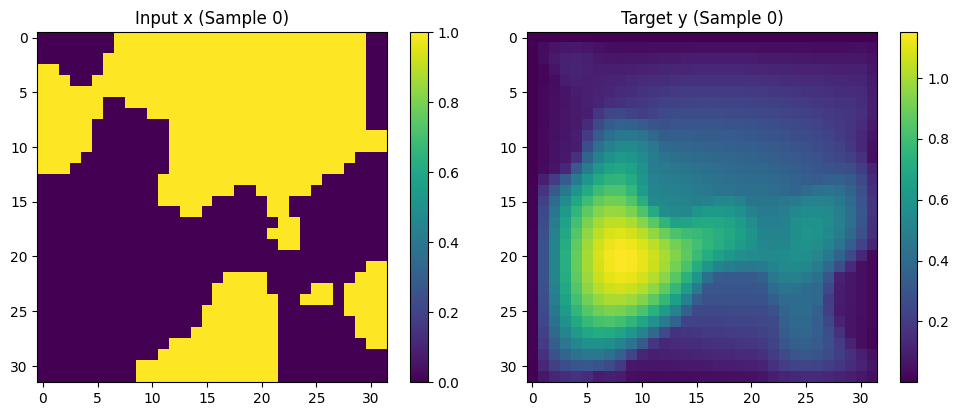

In [4]:
# 샘플 시각화
x_samples, y_samples = batch['x'], batch['y']
sample_idx = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(x_samples[sample_idx].squeeze(), cmap='viridis')
axes[0].set_title(f"Input x (Sample {sample_idx})")
axes[0].figure.colorbar(axes[0].images[0], ax=axes[0])

axes[1].imshow(y_samples[sample_idx].squeeze(), cmap='viridis')
axes[1].set_title(f"Target y (Sample {sample_idx})")
axes[1].figure.colorbar(axes[1].images[0], ax=axes[1])

plt.tight_layout()
plt.show()

In [24]:
# trunk 좌표 및 데이터 준비
xs = torch.linspace(0.0, 1.0, 32)
ys = torch.linspace(0.0, 1.0, 32)
X, Y = torch.meshgrid(xs, ys, indexing="ij")
trunk = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1).to(batch["x"].device)

# 데이터 준비 및 정규화
branch = batch["x"]
Y = batch["y"]

print(f'branch: {branch.shape}, trunk: {trunk.shape}, Y: {Y.shape}')

branch: torch.Size([50, 1, 32, 32]), trunk: torch.Size([1024, 2]), Y: torch.Size([50, 1, 32, 32])


In [25]:
class DeepONetDataset(Dataset):
    def __init__(self, data_loader, trunk_coords):
        self.branch_data = []
        self.target_data = []
        
        for batch in data_loader:
            B = batch["x"].size(0)
            branch = batch["x"]
            Y = batch["y"].view(B, -1)
            self.branch_data.append(branch)
            self.target_data.append(Y)
        
        self.branch_data = torch.cat(self.branch_data, dim=0)
        self.target_data = torch.cat(self.target_data, dim=0)
        
        self.trunk = trunk_coords
    
    def __len__(self):
        return len(self.branch_data)
    
    def __getitem__(self, index):
        return self.branch_data[index], self.target_data[index]

In [26]:
# 학습용 데이터셋 생성
train_dataset = DeepONetDataset(train_loader, trunk)
train_loader_fast = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=0, pin_memory=True)
print(len(train_dataset))

2000


In [27]:
class Network(torch.nn.Module):
    def __init__(self, trunk_dim=2, hidden_dim=256, hidden_dim2=512, output_dim=256):
        super().__init__()
        self.bias = nn.Parameter(torch.tensor(0.0))

        # Branch Net: CNN으로 변경
        # 입력: (B, 1, 32, 32) -> 출력: (B, output_dim)
        self.branch = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1), nn.ReLU(),
            
            # Flatten
            nn.Flatten(),
            
            # Fully Connected Layers
            nn.Linear(256*4*4, hidden_dim2), nn.ReLU(),
            nn.Linear(hidden_dim2, output_dim)
        )

        self.trunk = nn.Sequential(
            nn.Linear(trunk_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim2), nn.ReLU(),
            nn.Linear(hidden_dim2, output_dim)
        )
    
    def forward(self, branch, trunk):
        branch_out = self.branch(branch)
        trunk_out  = self.trunk(trunk) 
        out = branch_out @ trunk_out.T + self.bias
        return out

def init_weights(m): 
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_normal_(m.weight.data) 
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [28]:
model = Network()
model.apply(init_weights)
model = model.to(device)

In [29]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
# 학습
n_epochs = 10000

trunk = trunk.to(device)

for epoch in range(n_epochs):
    model.train()
    losses = []
    
    for branch_batch, Y_batch in train_loader_fast:
        branch_batch = branch_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        optimizer.zero_grad()
        pred = model(branch_batch, trunk)
        loss = loss_fn(pred, Y_batch)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    if epoch % 1000 == 0:
        avg_loss = np.mean(losses)
        print(f'Epoch: {epoch}, Loss: {avg_loss:.4f}')
        torch.save(model.state_dict(), "C:/Users/admin/Desktop/김도형/코드/model/darcy_deeponet_cnn_autosave.pt")

Epoch: 0, Loss: 0.1249
Epoch: 1000, Loss: 0.0004
Epoch: 2000, Loss: 0.0002
Epoch: 3000, Loss: 0.0002
Epoch: 4000, Loss: 0.0002
Epoch: 5000, Loss: 0.0002
Epoch: 6000, Loss: 0.0002
Epoch: 7000, Loss: 0.0002
Epoch: 8000, Loss: 0.0002
Epoch: 9000, Loss: 0.0002


In [14]:
test_batch = next(iter(test_loaders[32]))
print(test_batch.keys())
for k, v in test_batch.items():
    print(k, v.shape)

test_x_data = test_batch['x']
print(test_x_data.shape)

dict_keys(['x', 'y'])
x torch.Size([10, 1, 32, 32])
y torch.Size([10, 1, 32, 32])
torch.Size([10, 1, 32, 32])


Relative L2 Error: 8.70%


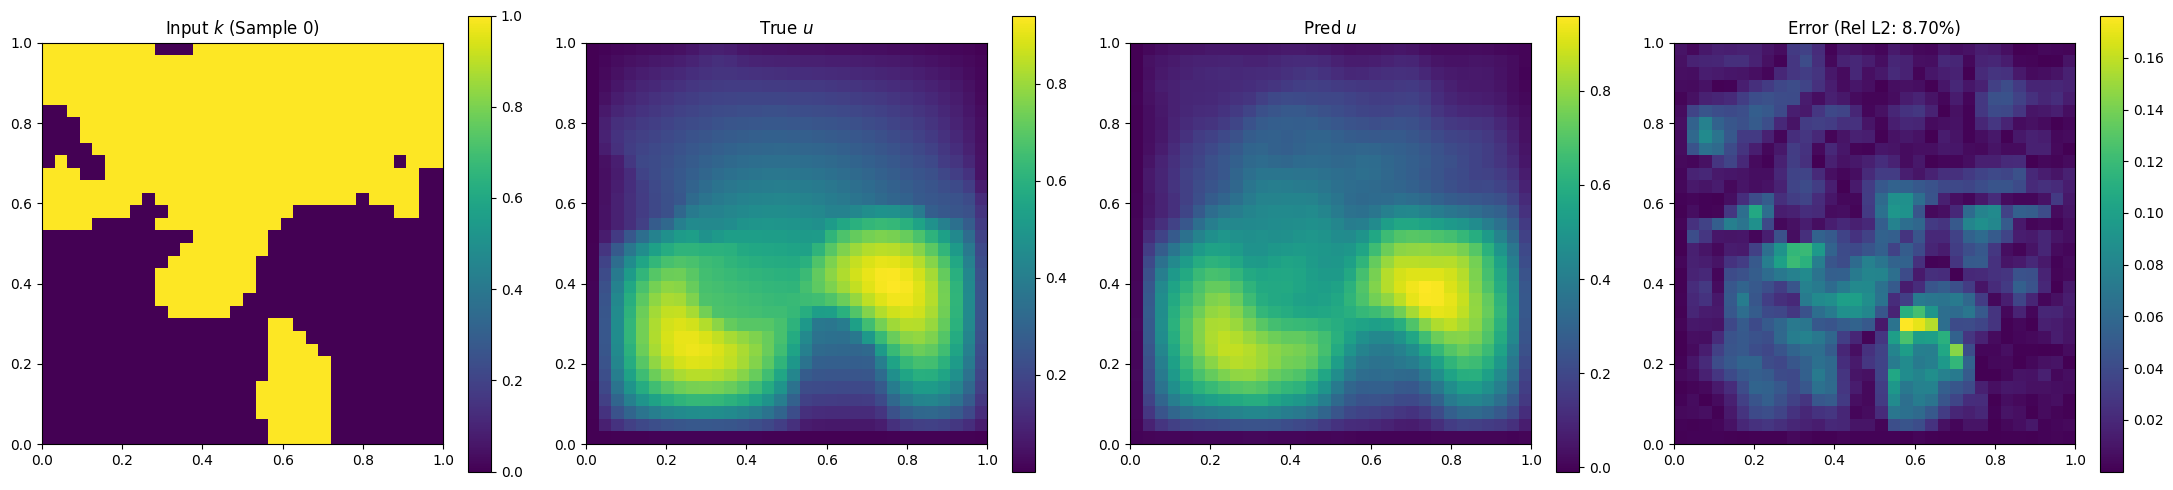

In [15]:
# 예측 및 시각화
idx = 0

k_sample = test_batch["x"][idx:idx+1].to(device)  # (1, 1, 32, 32)
u_true_raw = test_batch["y"][idx:idx+1].to(device)

model.eval()

with torch.no_grad():
    u_pred_flat = model(k_sample, trunk)  # k_sample은 이미 (1, 1, 32, 32) 형태
    
    u_pred = u_pred_flat.view(1, 1, 32, 32)
    u_pred = u_pred_flat.view(1, 1, 32, 32)

# numpy 변환
k_np = k_sample.squeeze().cpu().numpy()
u_true_np = u_true_raw.squeeze().cpu().numpy()
u_pred_np = u_pred.squeeze().cpu().numpy()
u_err = np.abs(u_pred_np - u_true_np)

# 상대 오차
rel_l2 = np.linalg.norm(u_true_np - u_pred_np) / (np.linalg.norm(u_true_np) + 1e-12) * 100
print(f"Relative L2 Error: {rel_l2:.2f}%")

# 시각화
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
extent = [0, 1, 0, 1]

axes[0].imshow(k_np.T, origin="lower", cmap="viridis", extent=extent)
axes[0].set_title(f"Input $k$ (Sample {idx})")
plt.colorbar(axes[0].images[0], ax=axes[0])

axes[1].imshow(u_true_np.T, origin="lower", cmap="viridis", extent=extent)
axes[1].set_title("True $u$")
plt.colorbar(axes[1].images[0], ax=axes[1])

axes[2].imshow(u_pred_np.T, origin="lower", cmap="viridis", extent=extent)
axes[2].set_title("Pred $u$")
plt.colorbar(axes[2].images[0], ax=axes[2])

axes[3].imshow(u_err.T, origin="lower", cmap="viridis", extent=extent)
axes[3].set_title(f"Error (Rel L2: {rel_l2:.2f}%)")
plt.colorbar(axes[3].images[0], ax=axes[3])

plt.tight_layout()
plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260213_labmeeting/sample_{idx}_result_cnn.png", 
            dpi=300, bbox_inches="tight")
plt.show()

In [16]:
import torch
import numpy as np

model.eval()

# 1. 테스트 데이터 준비 (Batch 단위로 바로 처리)
x_test = test_batch["x"].to(device)  # shape: (N, 1, 32, 32)
y_true = test_batch["y"].to(device)  # shape: (N, 1, 32, 32)

with torch.no_grad():
    # 모델 예측 (CNN 모델이므로 4차원 텐서를 입력으로 받음)
    u_pred_raw = model(x_test, trunk)
    
    # 출력 형상을 정답 데이터와 동일하게 (N, 1, 32, 32)로 변환
    u_pred = u_pred_raw.view(y_true.shape)

# 출력 헤더
print(f"{'Sample Index':<15} | {'Relative L2 Error (%)':<20}")
print("-" * 40)

# 2. 모든 샘플 순회하며 오차 계산
for i in range(len(x_test)):
    # 개별 샘플 추출 및 Numpy 변환
    true_np = y_true[i].cpu().numpy()
    pred_np = u_pred[i].cpu().numpy()
    
    # L2 Norm 계산
    diff_norm = np.linalg.norm(true_np - pred_np)
    true_norm = np.linalg.norm(true_np)
    
    # 상대 오차 계산 (%)
    rel_l2 = (diff_norm / (true_norm + 1e-12)) * 100
    
    # 결과 출력
    print(f"Sample {i:<8} | {rel_l2:.4f}%")

print("-" * 40)
print(f"Total samples processed: {len(x_test)}")

Sample Index    | Relative L2 Error (%)
----------------------------------------
Sample 0        | 8.7014%
Sample 1        | 7.2435%
Sample 2        | 8.2086%
Sample 3        | 8.0972%
Sample 4        | 11.2311%
Sample 5        | 22.5604%
Sample 6        | 13.4506%
Sample 7        | 14.3413%
Sample 8        | 14.3656%
Sample 9        | 14.1436%
----------------------------------------
Total samples processed: 10



[C:/Users/admin/Desktop/김도형/코드/model/darcy_deeponet_cnn_autosave.pt] 모델 테스트 중... (Target Res: 16x16)


C:\Users\admin\AppData\Local\Temp\ipykernel_19848\3387120550.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device) # 

총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['14.97%', '14.33%', '17.13%', '21.31%', '18.05%', '30.04%', '21.46%', '20.23%', '22.91%', '27.22%', '11.71%', '23.92%', '15.42%', '35.76%', '29.25%', '23.98%', '23.17%', '16.84%', '22.15%', '28.62%']
평균 Relative L2 Error: 21.92%


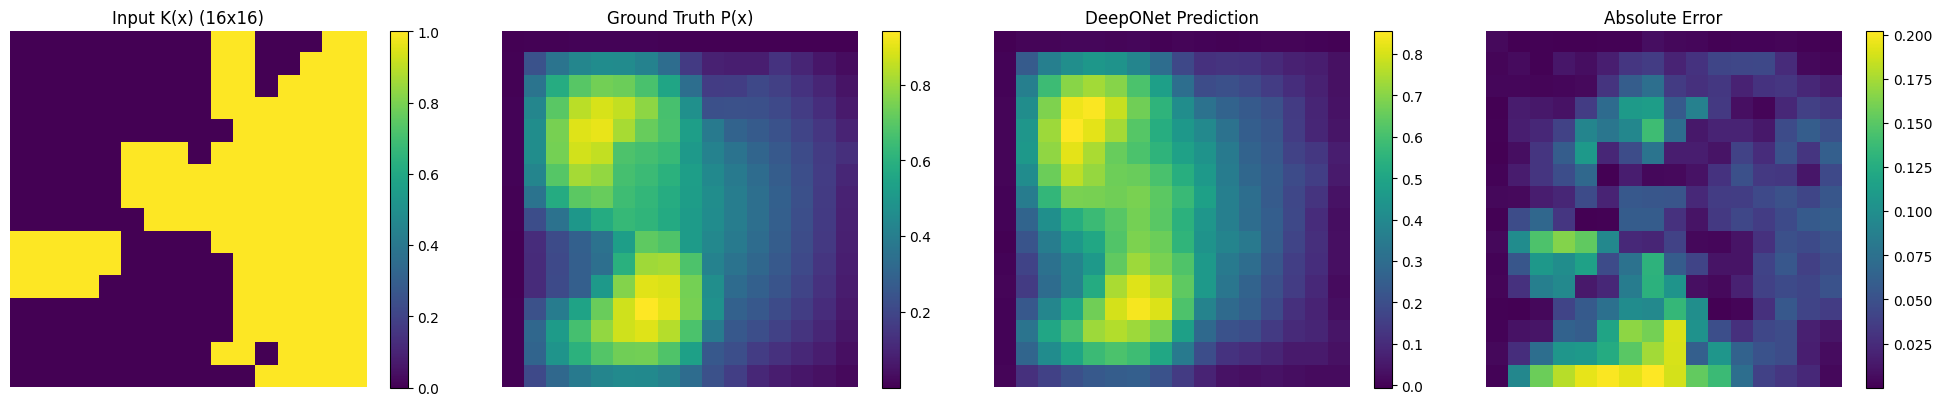

------------------------------------------------------------

[C:/Users/admin/Desktop/김도형/코드/model/darcy_deeponet_cnn_autosave.pt] 모델 테스트 중... (Target Res: 32x32)
총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['08.33%', '06.32%', '08.26%', '07.82%', '11.21%', '21.85%', '12.78%', '14.39%', '14.09%', '13.51%', '07.00%', '16.74%', '07.27%', '26.87%', '20.54%', '07.60%', '15.42%', '12.25%', '12.04%', '14.95%']
평균 Relative L2 Error: 12.96%


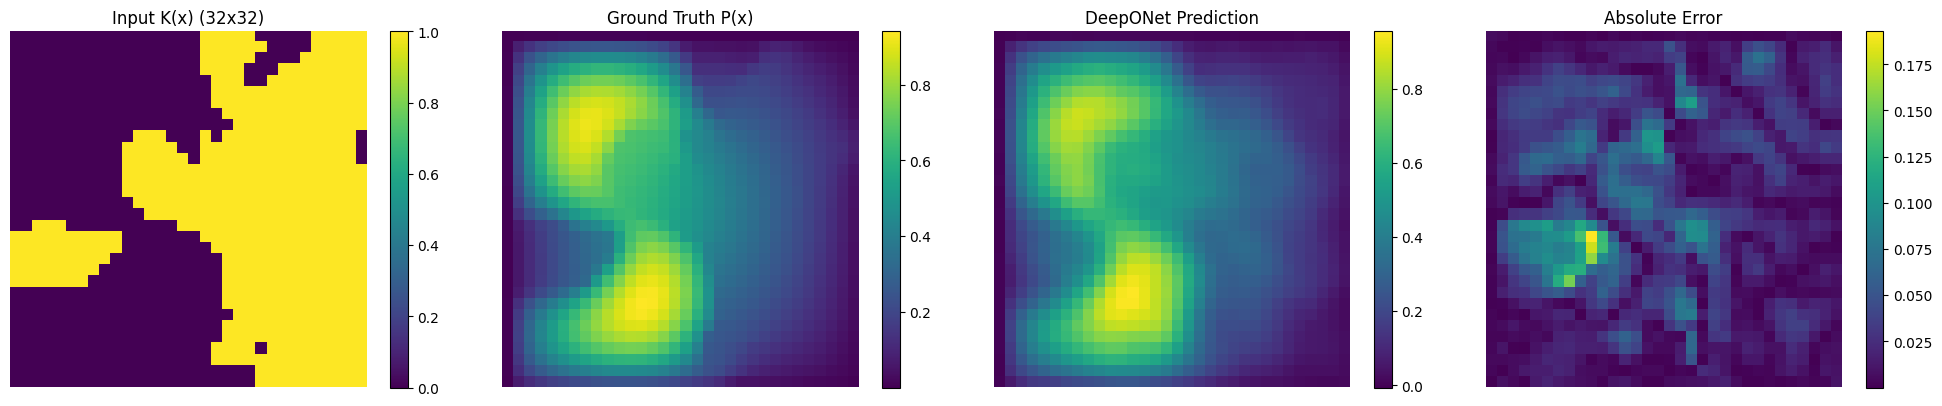

------------------------------------------------------------

[C:/Users/admin/Desktop/김도형/코드/model/darcy_deeponet_cnn_autosave.pt] 모델 테스트 중... (Target Res: 64x64)
총 테스트 샘플 수: 20
전체 샘플 Relative L2 Error: ['10.61%', '07.93%', '12.97%', '10.09%', '11.68%', '26.04%', '16.39%', '19.59%', '19.54%', '15.69%', '09.97%', '15.93%', '09.52%', '28.80%', '23.36%', '11.68%', '16.27%', '11.32%', '11.50%', '21.29%']
평균 Relative L2 Error: 15.51%


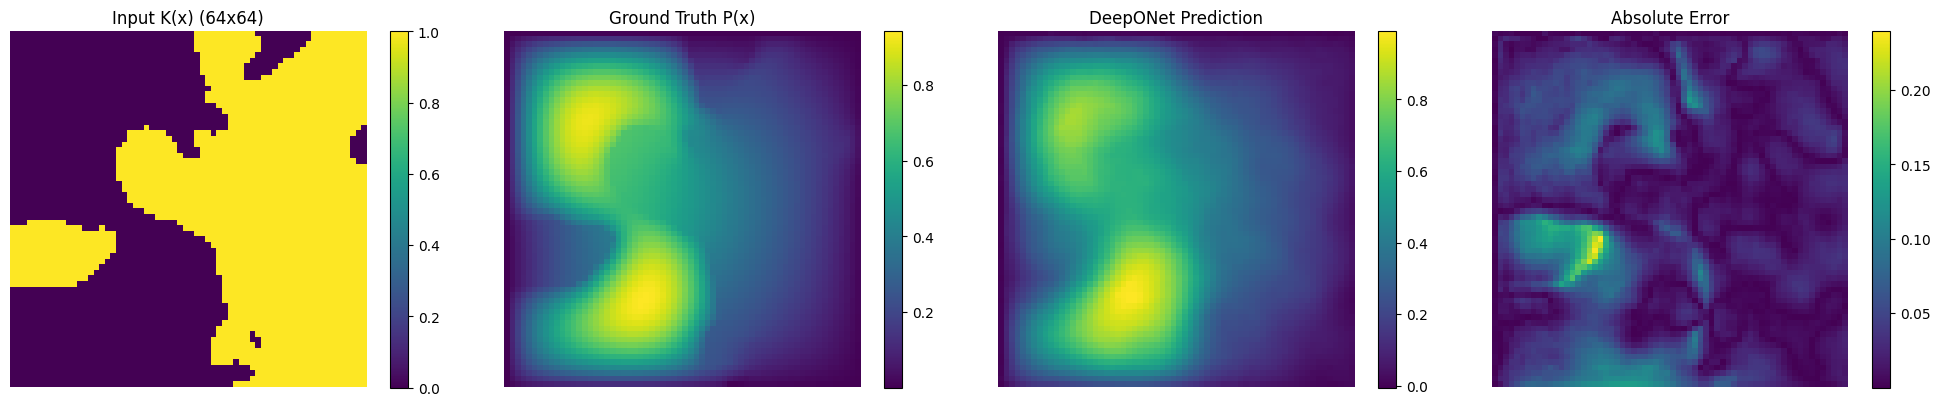

------------------------------------------------------------


In [38]:
import torch.nn.functional as F
# ==========================================
# 1. 유틸리티 함수 (좌표 생성, 평가)
# ==========================================
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def get_trunk_coords(resolution):
    """해상도에 맞는 Trunk 좌표(x, y) 생성"""
    xs = torch.linspace(0.0, 1.0, resolution)
    ys = torch.linspace(0.0, 1.0, resolution)
    X, Y = torch.meshgrid(xs, ys, indexing="ij")
    trunk = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=1).to(device)
    return trunk

def test_model(model_path, resolution, data_loader):
    """
    특정 모델 파일과 해상도에 대해 테스트를 수행하는 함수
    """
    print(f"\n[{model_path}] 모델 테스트 중... (Target Res: {resolution}x{resolution})")
    
    # 모델 초기화 (Network 클래스는 이미 메모리에 있다고 가정)
    # CNN 모델이므로 trunk_dim=2만 넣어서 초기화
    try:
        model = Network(trunk_dim=2).to(device)
    except NameError:
        print("오류: 'Network' 클래스가 정의되지 않았습니다. 위쪽 셀의 모델 정의 코드를 먼저 실행해주세요.")
        return
    
    # 가중치 로드
    try:
        checkpoint = torch.load(model_path, map_location=device) # weights_only=False는 필요시 추가
        
        if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        elif isinstance(checkpoint, dict):
            model.load_state_dict(checkpoint)
        else: # 모델 전체가 저장된 경우
            model = checkpoint
            
        model.eval()
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Trunk 좌표 생성
    trunk_input = get_trunk_coords(resolution)
    
    l2_errors = []
    vis_input, vis_true, vis_pred = None, None, None
    
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            
            # --- Branch 입력 전처리 (CNN 버전) ---
            # 1. 해상도 보간 (32x32로 고정)
            if x.shape[-1] != 32:
                branch_input = F.interpolate(x, size=(32, 32), mode='bilinear', align_corners=False)
            else:
                branch_input = x
            
            # 2. CNN은 Flatten 없이 이미지 형태 그대로 입력
            
            # 예측
            out_flat = model(branch_input, trunk_input)
            
            # 정답 평탄화
            true_flat = y.view(y.size(0), -1)
            
            # Relative L2 Error 계산
            diff_norm = torch.norm(out_flat - true_flat, p=2, dim=1)
            true_norm = torch.norm(true_flat, p=2, dim=1)
            batch_errors = diff_norm / (true_norm + 1e-6)
            
            l2_errors.extend(batch_errors.cpu().tolist())
            
            # 시각화용 데이터 저장 (첫 배치 첫 샘플)
            if i == 0:
                vis_input = x[0, 0].cpu().numpy()
                vis_true = y[0, 0].cpu().numpy()
                vis_pred = out_flat[0].view(resolution, resolution).cpu().numpy()

    # 결과 텍스트 출력
    avg_error = np.mean(l2_errors)
    
    print(f"총 테스트 샘플 수: {len(l2_errors)}")
    # 요청하신 포맷: ['00.00%', ...]
    formatted_errors = [f"{e*100:05.2f}%" for e in l2_errors]
    print(f"전체 샘플 Relative L2 Error: {formatted_errors}")
    print(f"평균 Relative L2 Error: {avg_error*100:.2f}%")
    
    # 결과 시각화
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    abs_error = np.abs(vis_true - vis_pred)
    
    titles = [f'Input K(x) ({resolution}x{resolution})', 
              'Ground Truth P(x)', 
              'DeepONet Prediction', 
              'Absolute Error']
    images = [vis_input, vis_true, vis_pred, abs_error]
    
    for ax, img, title in zip(axes, images, titles):
        im = ax.imshow(img, cmap='viridis')
        ax.set_title(title)
        plt.colorbar(im, ax=ax)
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(f"C:/Users/admin/Desktop/김도형/코드/figure_20260213_labmeeting/result_don_cnn_sample_{resolution}.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("-" * 60)

# ==========================================
# 2. 실행 (경로는 본인 환경에 맞게 수정하세요)
# ==========================================
model_file = "C:/Users/admin/Desktop/김도형/코드/model/darcy_deeponet_cnn_autosave.pt"

test_model(model_file, 16, test_loaders[16])
test_model(model_file, 32, test_loaders[32])
test_model(model_file, 64, test_loaders[64])